In [140]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.ensemble import IsolationForest
from pyod.models.iforest import IForest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt



In [2]:
df=pd.read_csv(r"C:\Users\adnan\Downloads\loan approval\train.csv",index_col='id')

In [3]:
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [6]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [7]:
df['person_home_ownership'].value_counts()

person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64

In [8]:
df['loan_intent'].value_counts()

loan_intent
EDUCATION            12271
MEDICAL              10934
PERSONAL             10016
VENTURE              10011
DEBTCONSOLIDATION     9133
HOMEIMPROVEMENT       6280
Name: count, dtype: int64

In [9]:
df['loan_grade'].value_counts()

loan_grade
A    20984
B    20400
C    11036
D     5034
E     1009
F      149
G       33
Name: count, dtype: int64

In [10]:
df['cb_person_default_on_file'].value_counts()

cb_person_default_on_file
N    49943
Y     8702
Name: count, dtype: int64

In [11]:
df['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [12]:
#### features transformation 
import pandas as pd

def one_hot_encode_columns(df, columns):
    """
    تقوم هذه الدالة بتحويل الأعمدة الفئوية إلى ترميز واحد (0 و 1).
    
    Args:
    df (pandas.DataFrame): إطار البيانات الذي يحتوي على الأعمدة الفئوية.
    columns (list): قائمة بأسماء الأعمدة التي نريد تحويلها.
    
    Returns:
    pandas.DataFrame: إطار البيانات بعد تحويل الأعمدة الفئوية إلى ترميز واحد.
    """
    
    # تحويل الأعمدة الفئوية إلى ترميز واحد
    df_e= pd.get_dummies(df, columns=columns, drop_first=True)
    
    return df_e

# مثال على كيفية استخدام الدالة
columns_to_encode = ['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file']
df_e = one_hot_encode_columns(df, columns_to_encode)



In [13]:
def convert_boolean_to_binary(df):
    """
    تقوم هذه الدالة بتحويل القيم المنطقية True/False إلى 0/1.
    
    Args:
    df (pandas.DataFrame): إطار البيانات الذي يحتوي على القيم المنطقية.
    
    Returns:
    pandas.DataFrame: إطار البيانات بعد تحويل القيم.
    """
    for column in df.columns:
        if df[column].dtype == 'bool':
            df[column] = df[column].astype(int)
    
    return df

# تحويل القيم المنطقية في البيانات
df_e = convert_boolean_to_binary(df_e)




In [14]:
df_e

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
id,,,,,,,,,,,,,,,,,,,,,,,
0,37,35000,0.0,6000,11.49,0.17,14,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
1,22,56000,6.0,4000,13.35,0.07,2,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,29,28800,8.0,6000,8.90,0.21,10,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3,30,70000,14.0,12000,11.11,0.17,5,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
4,22,60000,2.0,6000,6.92,0.10,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,5.0,25000,15.95,0.21,10,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
58641,28,28800,0.0,10000,12.73,0.35,8,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
58642,23,44000,7.0,6800,16.00,0.15,2,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0


In [15]:
# استخدام IForest للكشف عن القيم الشاذة
iso_forest = IForest(contamination=0.1)
iso_forest.fit(df_e)
outliers = iso_forest.labels_

# إضافة القيم الشاذة إلى DataFrame
df_e['outliers'] = outliers


In [16]:
df_e

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,outliers
id,,,,,,,,,,,,,,,,,,,,,,,,
0,37,35000,0.0,6000,11.49,0.17,14,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
1,22,56000,6.0,4000,13.35,0.07,2,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1
2,29,28800,8.0,6000,8.90,0.21,10,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,30,70000,14.0,12000,11.11,0.17,5,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0
4,22,60000,2.0,6000,6.92,0.10,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,5.0,25000,15.95,0.21,10,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1
58641,28,28800,0.0,10000,12.73,0.35,8,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
58642,23,44000,7.0,6800,16.00,0.15,2,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0


In [17]:
df_e_clean = df_e[df_e['outliers'] == 0]

In [18]:
df_e_clean['loan_status'].value_counts()

loan_status
0    47443
1     5337
Name: count, dtype: int64

In [19]:
df_e_clean

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,outliers
id,,,,,,,,,,,,,,,,,,,,,,,,
0,37,35000,0.0,6000,11.49,0.17,14,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
2,29,28800,8.0,6000,8.90,0.21,10,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,30,70000,14.0,12000,11.11,0.17,5,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0
4,22,60000,2.0,6000,6.92,0.10,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,27,45000,2.0,9000,8.94,0.20,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58639,22,70000,6.0,10000,7.29,0.14,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
58641,28,28800,0.0,10000,12.73,0.35,8,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
58642,23,44000,7.0,6800,16.00,0.15,2,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0


In [50]:
df_e_clean.drop(columns=['outliers'], inplace=True)

C:\Users\adnan\AppData\Local\Temp\ipykernel_17512\508600877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e_clean.drop(columns=['outliers'], inplace=True)


In [52]:
df_e_clean

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
id,,,,,,,,,,,,,,,,,,,,,,,
0,37,35000,0.0,6000,11.49,0.17,14,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
2,29,28800,8.0,6000,8.90,0.21,10,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3,30,70000,14.0,12000,11.11,0.17,5,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
4,22,60000,2.0,6000,6.92,0.10,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
5,27,45000,2.0,9000,8.94,0.20,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58639,22,70000,6.0,10000,7.29,0.14,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
58641,28,28800,0.0,10000,12.73,0.35,8,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
58642,23,44000,7.0,6800,16.00,0.15,2,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0


In [54]:
X=df_e_clean

In [58]:
y=X.pop('loan_status')

In [60]:
X

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
id,,,,,,,,,,,,,,,,,,,,,,
0,37,35000,0.0,6000,11.49,0.17,14,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
2,29,28800,8.0,6000,8.90,0.21,10,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3,30,70000,14.0,12000,11.11,0.17,5,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
4,22,60000,2.0,6000,6.92,0.10,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
5,27,45000,2.0,9000,8.94,0.20,5,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58639,22,70000,6.0,10000,7.29,0.14,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
58641,28,28800,0.0,10000,12.73,0.35,8,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
58642,23,44000,7.0,6800,16.00,0.15,2,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0


In [62]:
y

id
0        0
2        0
3        0
4        0
5        0
        ..
58639    0
58641    1
58642    1
58643    0
58644    0
Name: loan_status, Length: 52780, dtype: int64

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [128]:
scaler = StandardScaler()
model = LogisticRegression(max_iter=4000)

pipeline = Pipeline([('scaler', scaler), ('model', model)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=4000))])

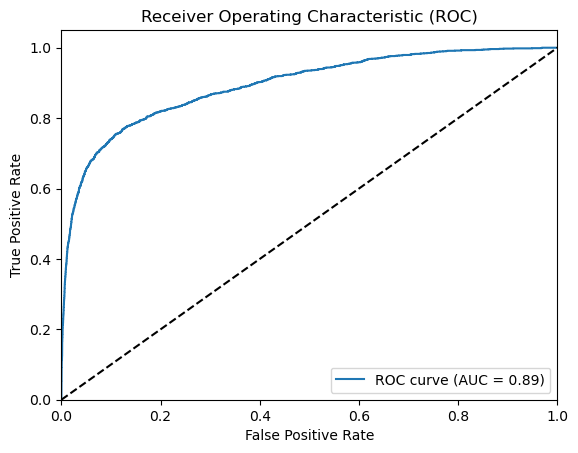

In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

# افتراض أن لديك بيانات X_train و y_train و X_test و y_test
# تحجيم البيانات باستخدام StandardScaler
scaler = StandardScaler()
model = LogisticRegression(max_iter=4000)

# إنشاء Pipeline لتحجيم البيانات وتدريب النموذج
pipeline = Pipeline([('scaler', scaler), ('model', model)])
pipeline.fit(X_train, y_train)

# حساب الاحتمالات المتوقعة
y_prob = pipeline.predict_proba(X_test)[:, 1]

# حساب القيم المطلوبة لـ ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# حساب المساحة تحت المنحنى AUC
auc_score = roc_auc_score(y_test, y_prob)

# رسم منحنى ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # الخط القاطع للتأكيد على الأداء العشوائي
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [172]:
x_test=pd.read_csv(r"C:\Users\adnan\Downloads\loan approval\test.csv",index_col='id')

In [174]:
x_test

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...
97738,22,31200,MORTGAGE,2.0,DEBTCONSOLIDATION,B,3000,10.37,0.10,N,4
97739,22,48000,MORTGAGE,6.0,EDUCATION,A,7000,6.03,0.15,N,3
97740,51,60000,MORTGAGE,0.0,PERSONAL,A,15000,7.51,0.25,N,25


In [186]:
columns_to_encode = ['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file']
x_test= one_hot_encode_columns(x_test, columns_to_encode)

In [188]:
x_test

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
id,,,,,,,,,,,,,,,,,,,,,,
58645,23,69000,3.0,25000,15.76,0.36,2,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False
58646,26,96000,6.0,10000,12.68,0.10,4,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True
58647,26,30000,5.0,4000,17.19,0.13,2,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True
58648,33,50000,4.0,7000,8.90,0.14,7,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
58649,26,102000,8.0,15000,16.32,0.15,4,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97738,22,31200,2.0,3000,10.37,0.10,4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
97739,22,48000,6.0,7000,6.03,0.15,3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
97740,51,60000,0.0,15000,7.51,0.25,25,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [190]:
x_test = convert_boolean_to_binary(x_test)

In [192]:
x_test

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
id,,,,,,,,,,,,,,,,,,,,,,
58645,23,69000,3.0,25000,15.76,0.36,2,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
58646,26,96000,6.0,10000,12.68,0.10,4,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
58647,26,30000,5.0,4000,17.19,0.13,2,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
58648,33,50000,4.0,7000,8.90,0.14,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
58649,26,102000,8.0,15000,16.32,0.15,4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97738,22,31200,2.0,3000,10.37,0.10,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
97739,22,48000,6.0,7000,6.03,0.15,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
97740,51,60000,0.0,15000,7.51,0.25,25,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [208]:
import pandas as pd

# افتراض أن لديك بيانات جديدة جديدة new_X
# تنبؤ بالخرج باستخدام الـ pipeline المدرب
new_predictions = pipeline.predict(x_test)

# إذا كنت ترغب في التنبؤ بالاحتمالات بدلاً من التنبؤات البسيطة
new_probabilities = pipeline.predict_proba(x_test)[:, 1]

# عرض النتائج
print("تنبؤات الخرج للبيانات الجديدة:")
print(new_predictions)

print("الاحتمالات المتوقعة للبيانات الجديدة:")
print(new_probabilities)

# يمكنك حفظ النتائج في ملف جديد إذا رغبت بذلك
new_data = pd.DataFrame(x_test)
new_data['predictions'] = new_predictions
new_data['probabilities'] = new_probabilities

new_data.to_csv('new_predictions.csv', index=False)


تنبؤات الخرج للبيانات الجديدة:
[1 0 0 ... 0 1 1]
الاحتمالات المتوقعة للبيانات الجديدة:
[0.89981262 0.00390301 0.16319508 ... 0.01719821 0.90105933 0.78500708]


In [258]:
import pandas as pd

# افتراض أن لديك بيانات جديدة تحتوي على الميزات المطلوبة فقط
id = x_test.index

# تنبؤ بالخرج باستخدام الـ pipeline المدرب
new_predictions = pipeline.predict(x_test)

# إنشاء DataFrame جديد يحتوي على الأعمدة 'index' و 'predictions'
res = pd.DataFrame({'index': id, 'predictions': new_predictions})

# عرض النتائج
print("تنبؤات الخرج للبيانات الجديدة:")
print(res)

# يمكنك حفظ النتائج في ملف جديد إذا رغبت بذلك
res.to_csv(r"C:\Users\adnan\Documents\loan_approval.csv", index=False)


تنبؤات الخرج للبيانات الجديدة:
       index  predictions
0      58645            1
1      58646            0
2      58647            0
3      58648            0
4      58649            0
...      ...          ...
39093  97738            0
39094  97739            0
39095  97740            0
39096  97741            1
39097  97742            1

[39098 rows x 2 columns]
